In [14]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from pymoo.algorithms.soo.nonconvex.pso import PSO
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import get_optimizing_joints, CalculateMultiCriteriaProblem, CalculateCriteriaProblemByWeigths
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT

In [15]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.29], 0.1, 0.24, 20, 40))

ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.05, -0.28], step_height=0.05, step_width=0.1, n_points=50))

left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.1, -0.28], step_height=0.05, step_width=0.1, n_points=50))

right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.0, -0.28], step_height=0.05, step_width=0.1, n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, -0.075, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.28, 0.08, 0.075, 50))

In [16]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0)

thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G":body_density},
                              thickness={"default": thickness, "EE":0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
)

In [17]:
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass()
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

In [18]:
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [workspace_trajectory])

# manager should be filled with trajectories and rewards using the manager API
acc_normilizing_reward_manager = RewardManager(crag=crag)
acc_normilizing_reward_manager.add_trajectory(ground_symmetric_step, 0)
acc_normilizing_reward_manager.add_trajectory(left_shift_step, 1)
acc_normilizing_reward_manager.add_trajectory(right_shift_step, 2)
acc_normilizing_reward_manager.add_reward(acceleration_capability, 0, 1)
acc_normilizing_reward_manager.add_reward(acceleration_capability, 1, 1)
acc_normilizing_reward_manager.add_reward(acceleration_capability, 2, 1)
acc_normilizing_reward_manager.add_trajectory_aggregator([0,1,2], 'mean')

hl_normilizing_reward_manager = RewardManager(crag=crag)
hl_normilizing_reward_manager.add_trajectory(central_vertical, 3)
hl_normilizing_reward_manager.add_trajectory(left_vertical, 4)
hl_normilizing_reward_manager.add_trajectory(right_vertical, 5)
hl_normilizing_reward_manager.add_reward(heavy_lifting, 3, 1)
hl_normilizing_reward_manager.add_reward(heavy_lifting, 4, 1)
hl_normilizing_reward_manager.add_reward(heavy_lifting, 5, 1)
hl_normilizing_reward_manager.add_trajectory_aggregator([3,4,5], 'mean')
# manager should be filled with trajectories and rewards using the manager API






In [19]:
# for _, trajectory in reward_manager.trajectories.items():
#     plt.plot(trajectory[:, 0], trajectory[:, 2])

# plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
# plt.show()

In [20]:

population_size = 32
n_generations = 200
n_generations_norm = 30
for i in range(6,7):
    # the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
    graph, constrain_dict = all_graphs[i]
    optimizing_joints = get_optimizing_joints(graph, constrain_dict)
    # create the problem for the current optimization
    problem = CalculateCriteriaProblemByWeigths(graph,builder, optimizing_joints, acc_normilizing_reward_manager, soft_constrain, elementwise_runner=runner, Actuator = actuator)

    algorithm = PSO(pop_size=population_size, save_history=False)
    optimizer = PymooOptimizer(problem, algorithm)

    res = optimizer.run(
        False, **{
            "seed": 4,
            "termination": ("n_gen", n_generations_norm),
            "verbose": False
        })
    best_id = np.argmin(optimizer.history["F"])
    best_x = optimizer.history["X"][best_id]
    best_reward = optimizer.history["F"][best_id]
    acceleration_capability_weight = 1/(-best_reward.item())
    # the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
    graph, constrain_dict = all_graphs[i]
    optimizing_joints = get_optimizing_joints(graph, constrain_dict)
    # create the problem for the current optimization
    problem = CalculateCriteriaProblemByWeigths(graph,builder, optimizing_joints, hl_normilizing_reward_manager, soft_constrain, elementwise_runner=runner, Actuator = actuator)

    algorithm = PSO(pop_size=population_size, save_history=False)
    optimizer = PymooOptimizer(problem, algorithm)

    res = optimizer.run(
        False, **{
            "seed": 4,
            "termination": ("n_gen", n_generations_norm),
            "verbose": False
        })
    best_id = np.argmin(optimizer.history["F"])
    best_x = optimizer.history["X"][best_id]
    best_reward = optimizer.history["F"][best_id]
    heavy_lifting_weight = 1/(-best_reward.item())
    # the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
    graph, constrain_dict = all_graphs[i]
    optimizing_joints = get_optimizing_joints(graph, constrain_dict)
    
    reward_manager = RewardManager(crag=crag)
    reward_manager.add_trajectory(ground_symmetric_step, 0)
    reward_manager.add_trajectory(left_shift_step, 1)
    reward_manager.add_trajectory(right_shift_step, 2)
    reward_manager.add_trajectory(central_vertical, 3)
    reward_manager.add_trajectory(left_vertical, 4)
    reward_manager.add_trajectory(right_vertical, 5)
    reward_manager.add_reward(acceleration_capability, 0, acceleration_capability_weight)
    reward_manager.add_reward(acceleration_capability, 1, acceleration_capability_weight)
    reward_manager.add_reward(acceleration_capability, 2, acceleration_capability_weight)
    reward_manager.add_reward(heavy_lifting, 3, heavy_lifting_weight)
    reward_manager.add_reward(heavy_lifting, 4, heavy_lifting_weight)
    reward_manager.add_reward(heavy_lifting, 5, heavy_lifting_weight)
    reward_manager.add_trajectory_aggregator([0,1,2], 'mean')
    reward_manager.add_trajectory_aggregator([3,4,5], 'mean')
    # create the problem for the current optimization
    problem = CalculateCriteriaProblemByWeigths(graph,builder, optimizing_joints, reward_manager, soft_constrain, elementwise_runner=runner, Actuator = actuator)

    saver = ProblemSaver(problem, f"prikol_1_single_normilized\\topology_{i}", True)
    saver.save_nonmutable()
    algorithm = PSO(pop_size=population_size, save_history=True)
    optimizer = PymooOptimizer(problem, algorithm, saver)

    res = optimizer.run(
        True, **{
            "seed": 4,
            "termination": ("n_gen", n_generations),
            "verbose": True
        })


LinAlgError: Singular matrix

In [ ]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("Best reward in :", -best_reward)

Best reward in : [1.72617489]


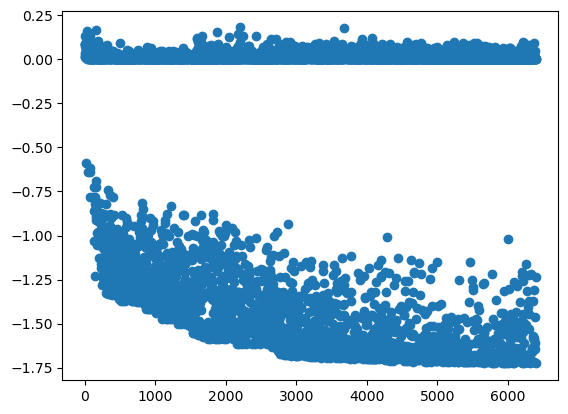

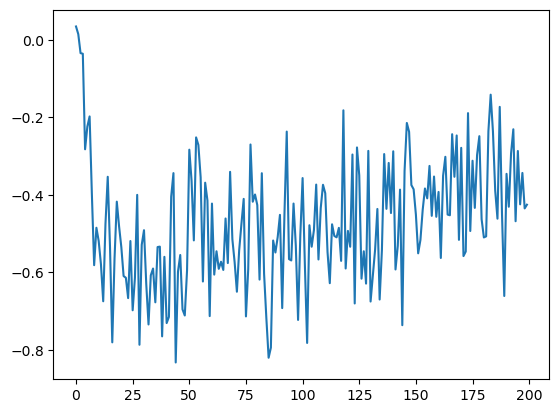

In [ ]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

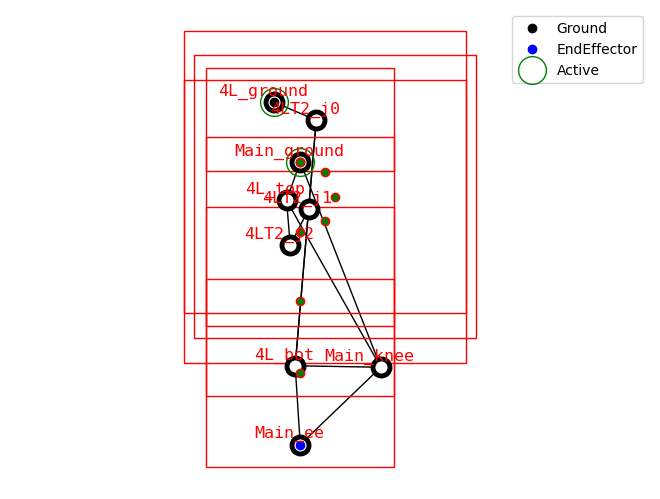

In [ ]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
visualize_constrains(problem.graph, constrain_dict)

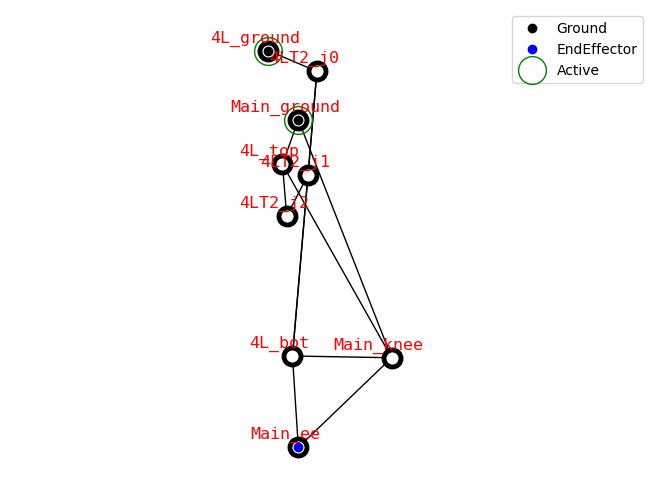

In [ ]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)